In [1]:
# 预测房价：回归问题
# 将要预测 20 世纪 70 年代中期波士顿郊区房屋价格的中位数，已知当时郊区的一些数据点，比如犯罪率、当地房产税率等。
# 用到的数据集与前面两个例子有一个有趣的区别:
# 它包含的数据点相对较少，只有 506 个，分为 404 个训练样本和 102 个测试样本。
# 输入数据的每个特征（比如犯罪率）都有不同的取值范围。例如，有些特性是比例，取值范围为 0~1；有的取值范围为 1~12；还有的取值范围为 0~100

In [2]:
from keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data(r'D:\boston_housing')

Using TensorFlow backend.


57344/57026 [==============================] - 1s 19us/step


In [5]:
print(train_data.shape)
print(train_targets.shape)
print(test_data.shape)
print(test_targets.shape)
print(train_data[0])
print(train_targets[0])

(404, 13)
(404,)
(102, 13)
(102,)
[  1.23247   0.        8.14      0.        0.538     6.142    91.7
   3.9769    4.      307.       21.      396.9      18.72   ]
15.2


In [9]:
# 将取值范围差异很大的数据输入到神经网络中，学习肯定变得更加困难。
# 对于这种数据，普遍采用的最佳实践是对每个特征做标准化，
# 即对于输入数据的每个特征（输入数据矩阵中的列），减去特征平均值，再除以标准差，这样得到的特征平均值为 0，标准差为 1
import numpy as np
X = np.array([[1, 2], [4, 5], [7, 8]])
print(np.mean(X, axis=0, keepdims=True))# axis=n 表示第n维度被压缩成1维
print(np.mean(X, axis=1, keepdims=True))

[[4. 5.]]
[[1.5]
 [4.5]
 [7.5]]


In [10]:
mean=train_data.mean(axis=0)
train_data-=mean
std=train_data.std(axis=0)
train_data/=std
test_data-=mean
test_data/=std
# 注意，用于测试数据标准化的均值和标准差都是在训练数据上计算得到的。在工作流程中，
# 不能使用在测试数据上计算得到的任何结果，即使是像数据标准化这么简单的事情也不行

In [19]:
# 由于样本数量很少，我们将使用一个非常小的网络，其中包含两个隐藏层，每层有 64 个单元。
# 一般来说，训练数据越少，过拟合会越严重，而较小的网络可以降低过拟合。
from keras import models
from keras import layers
def build_model():
    model=models.Sequential()
    model.add(layers.Dense(64,activation='relu',input_shape=(13,)))
    model.add(layers.Dense(64,activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop',loss='mse',metrics=['mae'])
    return model
# 网络的最后一层只有一个单元，没有激活，是一个线性层。这是标量回归（标量回归是预测单一连续值的回归）的典型设置。
# 添加激活函数将会限制输出范围。
# 例如，如果向最后一层添加 sigmoid 激活函数，网络只能学会预测 0~1 范围内的值。
# 这里最后一层是纯线性的，所以网络可以学会预测任意范围内的值。
# 注意，编译网络用的是 mse 损失函数，即均方误差（MSE，mean squared error），预测值与目标值之差的平方。这是回归问题常用的损失函数。
# 在训练过程中还监控一个新指标：平均绝对误差（MAE，mean absolute error）。它是预测值与目标值之差的绝对值。
# 比如，如果这个问题的 MAE 等于 0.5，就表示你预测的房价与实际价格平均相差 500 美元。

In [23]:
# K折交叉验证
# 由于数据点很少，验证集会非常小（比如大约100 个样本）。
# 在这种情况下，最佳做法是使用 K 折交叉验证（见图 3-11）。
# 这种方法将可用数据划分为 K个分区（K 通常取 4 或 5），实例化 K 个相同的模型，将每个模型在 K-1 个分区上训练，
# 并在剩下的一个分区上进行评估。
# 模型的验证分数等于 K 个验证分数的平均值。
import numpy as np
k=4
num_val_samples=len(train_data)//k
all_scores=[]
for i in range(k):
    print('process fold #',i)
    val_data=train_data[i*num_val_samples:(i+1)*num_val_samples]
    val_targets=train_targets[i*num_val_samples:(i+1)*num_val_samples]
    partial_train_data=np.concatenate([train_data[:i * num_val_samples],train_data[(i + 1) * num_val_samples:]],axis=0)# 拼接函数
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],train_targets[(i + 1) * num_val_samples:]],axis=0)# 拼接函数
    model=build_model()
    model.fit(partial_train_data,partial_train_targets,epochs=100,batch_size=1,verbose=1)# 训练模型（静默模式，verbose=0 ）
    # fit 中的 verbose
    # verbose：日志显示
    # verbose = 0 为不在标准输出流输出日志信息
    # verbose = 1 为输出进度条记录
    # verbose = 2 为每个epoch输出一行记录
    # 注意： 默认为 1
    val_mse,val_mae = model.evaluate(val_data, val_targets, verbose=2)
    all_scores.append(val_mae)

process fold # 0
Epoch 1/100
303/303 [==============================] - 1s 4ms/step - loss: 241.0787 - mae: 11.9688
Epoch 2/100
303/303 [==============================] - 1s 3ms/step - loss: 31.0741 - mae: 3.7614
Epoch 3/100
303/303 [==============================] - 1s 3ms/step - loss: 22.5838 - mae: 3.1168
Epoch 4/100
303/303 [==============================] - 1s 4ms/step - loss: 20.2497 - mae: 2.8512
Epoch 5/100
303/303 [==============================] - 1s 3ms/step - loss: 18.1955 - mae: 2.7133
Epoch 6/100
303/303 [==============================] - 1s 3ms/step - loss: 17.1498 - mae: 2.5995
Epoch 7/100
303/303 [==============================] - 1s 3ms/step - loss: 15.8158 - mae: 2.5044
Epoch 8/100
303/303 [==============================] - 1s 4ms/step - loss: 14.5053 - mae: 2.4474
Epoch 9/100
303/303 [==============================] - 1s 4ms/step - loss: 14.3516 - mae: 2.3375
Epoch 10/100
303/303 [==============================] - 1s 4ms/step - loss: 13.7320 - mae: 2.3515
Epoch 11/1

303/303 [==============================] - ETA: 0s - loss: 5.1233 - mae: 1.413 - 1s 4ms/step - loss: 5.0593 - mae: 1.4007
Epoch 85/100
303/303 [==============================] - 1s 3ms/step - loss: 4.7457 - mae: 1.4277
Epoch 86/100
303/303 [==============================] - 1s 4ms/step - loss: 4.9932 - mae: 1.4378
Epoch 87/100
303/303 [==============================] - 1s 4ms/step - loss: 5.1628 - mae: 1.4509
Epoch 88/100
303/303 [==============================] - 2s 5ms/step - loss: 4.6333 - mae: 1.3863
Epoch 89/100
303/303 [==============================] - 1s 5ms/step - loss: 4.5602 - mae: 1.4110
Epoch 90/100
303/303 [==============================] - 1s 3ms/step - loss: 4.9797 - mae: 1.3946
Epoch 91/100
303/303 [==============================] - 1s 3ms/step - loss: 4.9077 - mae: 1.4115
Epoch 92/100
303/303 [==============================] - 1s 4ms/step - loss: 4.5493 - mae: 1.3888
Epoch 93/100
303/303 [==============================] - 1s 4ms/step - loss: 5.0256 - mae: 1.3541
Epoch

303/303 [==============================] - 1s 3ms/step - loss: 5.4228 - mae: 1.5556
Epoch 67/100
303/303 [==============================] - 1s 4ms/step - loss: 5.6192 - mae: 1.5543
Epoch 68/100
303/303 [==============================] - 1s 3ms/step - loss: 5.5225 - mae: 1.5418
Epoch 69/100
303/303 [==============================] - 1s 3ms/step - loss: 5.4355 - mae: 1.5275
Epoch 70/100
303/303 [==============================] - 1s 3ms/step - loss: 5.2145 - mae: 1.4949
Epoch 71/100
303/303 [==============================] - 1s 3ms/step - loss: 5.2436 - mae: 1.5076
Epoch 72/100
303/303 [==============================] - 1s 3ms/step - loss: 5.1959 - mae: 1.4899
Epoch 73/100
303/303 [==============================] - 1s 3ms/step - loss: 4.8733 - mae: 1.4795
Epoch 74/100
303/303 [==============================] - 1s 3ms/step - loss: 5.0593 - mae: 1.5054
Epoch 75/100
303/303 [==============================] - 1s 3ms/step - loss: 4.7445 - mae: 1.4350
Epoch 76/100
303/303 [=====================

303/303 [==============================] - 1s 3ms/step - loss: 5.1426 - mae: 1.5432
Epoch 51/100
303/303 [==============================] - 1s 3ms/step - loss: 5.1400 - mae: 1.5952
Epoch 52/100
303/303 [==============================] - 2s 7ms/step - loss: 4.9140 - mae: 1.5499A: 3
Epoch 53/100
303/303 [==============================] - 1s 4ms/step - loss: 5.1032 - mae: 1.5346
Epoch 54/100
303/303 [==============================] - 1s 2ms/step - loss: 5.1440 - mae: 1.5364
Epoch 55/100
303/303 [==============================] - 0s 1ms/step - loss: 4.6453 - mae: 1.4960
Epoch 56/100
303/303 [==============================] - 0s 1ms/step - loss: 5.2126 - mae: 1.5914
Epoch 57/100
303/303 [==============================] - 0s 1ms/step - loss: 4.6984 - mae: 1.5073
Epoch 58/100
303/303 [==============================] - 0s 1ms/step - loss: 4.7215 - mae: 1.4884
Epoch 59/100
303/303 [==============================] - 0s 960us/step - loss: 4.7224 - mae: 1.5429
Epoch 60/100
303/303 [===============

303/303 [==============================] - 0s 911us/step - loss: 6.7518 - mae: 1.7916
Epoch 34/100
303/303 [==============================] - 0s 888us/step - loss: 6.6322 - mae: 1.7357
Epoch 35/100
303/303 [==============================] - 0s 869us/step - loss: 7.0577 - mae: 1.7158
Epoch 36/100
303/303 [==============================] - 0s 859us/step - loss: 6.4545 - mae: 1.7140
Epoch 37/100
303/303 [==============================] - 0s 883us/step - loss: 6.5126 - mae: 1.6791
Epoch 38/100
303/303 [==============================] - 0s 867us/step - loss: 6.6686 - mae: 1.6967
Epoch 39/100
303/303 [==============================] - 0s 878us/step - loss: 6.4224 - mae: 1.6239
Epoch 40/100
303/303 [==============================] - 0s 877us/step - loss: 6.0831 - mae: 1.6621
Epoch 41/100
303/303 [==============================] - 0s 876us/step - loss: 6.1392 - mae: 1.6375
Epoch 42/100
303/303 [==============================] - 0s 879us/step - loss: 5.9424 - mae: 1.6436
Epoch 43/100
303/303 [=

In [24]:
print(all_scores)
print(np.mean(all_scores))

[1.9668362140655518, 2.51318621635437, 2.531215190887451, 2.4771177768707275]
2.372088849544525


In [28]:
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate([train_data[:i * num_val_samples],train_data[(i + 1) * num_val_samples:]],axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],train_targets[(i + 1) * num_val_samples:]],axis=0)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,validation_data=(val_data, val_targets),epochs=500, batch_size=1, verbose=1)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

processing fold # 0
Train on 303 samples, validate on 101 samples
Epoch 1/500
303/303 [==============================] - 2s 7ms/step - loss: 219.8149 - mae: 11.1541 - val_loss: 34.2074 - val_mae: 3.7429
Epoch 2/500
303/303 [==============================] - 1s 5ms/step - loss: 29.0977 - mae: 3.7412 - val_loss: 23.2406 - val_mae: 3.1963
Epoch 3/500
303/303 [==============================] - 2s 7ms/step - loss: 21.9380 - mae: 3.1300 - val_loss: 18.3819 - val_mae: 2.5821
Epoch 4/500
303/303 [==============================] - 1s 5ms/step - loss: 18.6305 - mae: 2.8888 - val_loss: 15.8103 - val_mae: 2.4214
Epoch 5/500
303/303 [==============================] - 1s 4ms/step - loss: 16.3568 - mae: 2.7255 - val_loss: 13.9411 - val_mae: 2.2175
Epoch 6/500
303/303 [==============================] - 1s 4ms/step - loss: 15.0024 - mae: 2.4886 - val_loss: 12.6375 - val_mae: 2.2010
Epoch 7/500
303/303 [==============================] - 1s 4ms/step - loss: 13.8321 - mae: 2.4782 - val_loss: 12.6628 - val

303/303 [==============================] - 0s 1ms/step - loss: 6.0233 - mae: 1.6225 - val_loss: 7.7460 - val_mae: 1.9781
Epoch 62/500
303/303 [==============================] - 0s 1ms/step - loss: 5.7030 - mae: 1.6596 - val_loss: 7.7040 - val_mae: 1.9344
Epoch 63/500
303/303 [==============================] - 0s 1ms/step - loss: 6.0995 - mae: 1.5711 - val_loss: 7.4144 - val_mae: 1.8587
Epoch 64/500
303/303 [==============================] - 0s 1ms/step - loss: 5.3940 - mae: 1.6059 - val_loss: 8.1567 - val_mae: 1.9977
Epoch 65/500
303/303 [==============================] - 0s 1ms/step - loss: 6.0437 - mae: 1.5960 - val_loss: 7.3233 - val_mae: 1.9996
Epoch 66/500
303/303 [==============================] - 0s 1ms/step - loss: 5.2650 - mae: 1.5524 - val_loss: 7.6876 - val_mae: 1.8475
Epoch 67/500
303/303 [==============================] - 0s 1ms/step - loss: 5.7446 - mae: 1.5859 - val_loss: 7.9751 - val_mae: 2.0384
Epoch 68/500
303/303 [==============================] - 0s 2ms/step - loss:

303/303 [==============================] - 0s 1ms/step - loss: 3.5621 - mae: 1.2293 - val_loss: 9.1659 - val_mae: 2.2432
Epoch 123/500
303/303 [==============================] - 0s 1ms/step - loss: 3.5274 - mae: 1.2669 - val_loss: 8.9425 - val_mae: 2.0910
Epoch 124/500
303/303 [==============================] - 0s 1ms/step - loss: 3.7056 - mae: 1.3160 - val_loss: 8.9894 - val_mae: 2.0516
Epoch 125/500
303/303 [==============================] - 0s 1ms/step - loss: 3.2525 - mae: 1.2717 - val_loss: 11.2036 - val_mae: 2.4326
Epoch 126/500
303/303 [==============================] - 0s 1ms/step - loss: 3.4198 - mae: 1.2897 - val_loss: 12.1010 - val_mae: 2.3897
Epoch 127/500
303/303 [==============================] - 0s 1ms/step - loss: 3.2749 - mae: 1.2534 - val_loss: 9.4346 - val_mae: 2.3183
Epoch 128/500
303/303 [==============================] - 0s 1ms/step - loss: 3.2412 - mae: 1.2753 - val_loss: 9.4475 - val_mae: 2.2118
Epoch 129/500
303/303 [==============================] - 0s 1ms/ste

303/303 [==============================] - 2s 6ms/step - loss: 2.3795 - mae: 1.0711 - val_loss: 9.9516 - val_mae: 2.1915
Epoch 183/500
303/303 [==============================] - 2s 6ms/step - loss: 2.2452 - mae: 1.1190 - val_loss: 10.7293 - val_mae: 2.4378
Epoch 184/500
303/303 [==============================] - 2s 5ms/step - loss: 2.2274 - mae: 1.0986 - val_loss: 10.4701 - val_mae: 2.2780
Epoch 185/500
303/303 [==============================] - 1s 5ms/step - loss: 2.1982 - mae: 1.0811 - val_loss: 10.7903 - val_mae: 2.3581
Epoch 186/500
303/303 [==============================] - 2s 5ms/step - loss: 2.0651 - mae: 1.0396 - val_loss: 10.7163 - val_mae: 2.1825
Epoch 187/500
303/303 [==============================] - 2s 6ms/step - loss: 2.2827 - mae: 1.0773 - val_loss: 10.0216 - val_mae: 2.1888
Epoch 188/500
303/303 [==============================] - 2s 5ms/step - loss: 2.2910 - mae: 1.0658 - val_loss: 10.9031 - val_mae: 2.3803
Epoch 189/500
303/303 [==============================] - 1s 5ms

303/303 [==============================] - 1s 4ms/step - loss: 1.7717 - mae: 0.9612 - val_loss: 12.1746 - val_mae: 2.4261
Epoch 243/500
303/303 [==============================] - 1s 4ms/step - loss: 1.4640 - mae: 0.8868 - val_loss: 11.9438 - val_mae: 2.4530
Epoch 244/500
303/303 [==============================] - 1s 4ms/step - loss: 1.6670 - mae: 0.9258 - val_loss: 11.8429 - val_mae: 2.4914
Epoch 245/500
303/303 [==============================] - 1s 5ms/step - loss: 1.7799 - mae: 0.9251 - val_loss: 12.2853 - val_mae: 2.6759
Epoch 246/500
303/303 [==============================] - 1s 5ms/step - loss: 1.6744 - mae: 0.9494 - val_loss: 11.5663 - val_mae: 2.2861
Epoch 247/500
303/303 [==============================] - 1s 4ms/step - loss: 1.7326 - mae: 0.9389 - val_loss: 11.3909 - val_mae: 2.3979
Epoch 248/500
303/303 [==============================] - 2s 5ms/step - loss: 1.5250 - mae: 0.8954 - val_loss: 10.0646 - val_mae: 2.0867
Epoch 249/500
303/303 [==============================] - 1s 4m

303/303 [==============================] - 2s 5ms/step - loss: 1.2486 - mae: 0.8073 - val_loss: 11.5692 - val_mae: 2.3981
Epoch 303/500
303/303 [==============================] - 1s 5ms/step - loss: 1.4029 - mae: 0.8534 - val_loss: 10.5317 - val_mae: 2.1590
Epoch 304/500
303/303 [==============================] - 1s 4ms/step - loss: 1.4147 - mae: 0.8360 - val_loss: 11.6738 - val_mae: 2.3677
Epoch 305/500
303/303 [==============================] - 2s 5ms/step - loss: 1.3942 - mae: 0.8159 - val_loss: 11.4060 - val_mae: 2.3330
Epoch 306/500
303/303 [==============================] - 1s 4ms/step - loss: 1.3490 - mae: 0.8397 - val_loss: 11.9591 - val_mae: 2.3938
Epoch 307/500
303/303 [==============================] - 1s 4ms/step - loss: 1.3442 - mae: 0.8268 - val_loss: 11.5442 - val_mae: 2.2263
Epoch 308/500
303/303 [==============================] - 1s 4ms/step - loss: 1.3520 - mae: 0.8197 - val_loss: 12.5201 - val_mae: 2.6046
Epoch 309/500
303/303 [==============================] - 1s 4m

303/303 [==============================] - 1s 5ms/step - loss: 1.1626 - mae: 0.7786 - val_loss: 11.8490 - val_mae: 2.3437
Epoch 363/500
303/303 [==============================] - 2s 6ms/step - loss: 1.0764 - mae: 0.7298 - val_loss: 12.3557 - val_mae: 2.5747
Epoch 364/500
303/303 [==============================] - 1s 4ms/step - loss: 1.1725 - mae: 0.7460 - val_loss: 12.0652 - val_mae: 2.3377
Epoch 365/500
303/303 [==============================] - 1s 4ms/step - loss: 1.1729 - mae: 0.7973 - val_loss: 12.9093 - val_mae: 2.5164
Epoch 366/500
303/303 [==============================] - 2s 7ms/step - loss: 1.0076 - mae: 0.7346 - val_loss: 13.1660 - val_mae: 2.6208
Epoch 367/500
303/303 [==============================] - 2s 6ms/step - loss: 1.1124 - mae: 0.7532 - val_loss: 13.4597 - val_mae: 2.5567
Epoch 368/500
303/303 [==============================] - 2s 5ms/step - loss: 1.1623 - mae: 0.7990 - val_loss: 12.9006 - val_mae: 2.6063
Epoch 369/500
303/303 [==============================] - 2s 5m

303/303 [==============================] - 0s 1ms/step - loss: 0.8106 - mae: 0.6686 - val_loss: 12.6653 - val_mae: 2.6383
Epoch 423/500
303/303 [==============================] - 0s 1ms/step - loss: 1.0690 - mae: 0.7520 - val_loss: 12.9634 - val_mae: 2.6130
Epoch 424/500
303/303 [==============================] - 0s 1ms/step - loss: 0.8646 - mae: 0.6994 - val_loss: 12.2566 - val_mae: 2.5413
Epoch 425/500
303/303 [==============================] - 0s 1ms/step - loss: 0.9780 - mae: 0.6811 - val_loss: 13.8214 - val_mae: 2.7254
Epoch 426/500
303/303 [==============================] - 0s 1ms/step - loss: 0.9548 - mae: 0.7100 - val_loss: 11.7381 - val_mae: 2.4286
Epoch 427/500
303/303 [==============================] - 0s 1ms/step - loss: 0.9547 - mae: 0.6783 - val_loss: 12.8661 - val_mae: 2.5882
Epoch 428/500
303/303 [==============================] - 0s 1ms/step - loss: 1.0152 - mae: 0.7228 - val_loss: 13.4446 - val_mae: 2.5981
Epoch 429/500
303/303 [==============================] - 0s 1m

303/303 [==============================] - 1s 4ms/step - loss: 0.9319 - mae: 0.6889 - val_loss: 12.8982 - val_mae: 2.4759
Epoch 483/500
303/303 [==============================] - 1s 4ms/step - loss: 0.8379 - mae: 0.6644 - val_loss: 12.2047 - val_mae: 2.5091
Epoch 484/500
303/303 [==============================] - 2s 6ms/step - loss: 0.7907 - mae: 0.6378 - val_loss: 11.5522 - val_mae: 2.4293
Epoch 485/500
303/303 [==============================] - 1s 5ms/step - loss: 0.8546 - mae: 0.7073 - val_loss: 12.6190 - val_mae: 2.5246
Epoch 486/500
303/303 [==============================] - 2s 6ms/step - loss: 0.9961 - mae: 0.6867 - val_loss: 11.7111 - val_mae: 2.4815
Epoch 487/500
303/303 [==============================] - 2s 5ms/step - loss: 0.9864 - mae: 0.6686 - val_loss: 11.6990 - val_mae: 2.4230
Epoch 488/500
303/303 [==============================] - 1s 4ms/step - loss: 0.8502 - mae: 0.6814 - val_loss: 11.7045 - val_mae: 2.4934
Epoch 489/500
303/303 [==============================] - 1s 4m

303/303 [==============================] - 1s 4ms/step - loss: 6.9378 - mae: 1.7050 - val_loss: 11.2684 - val_mae: 2.5955
Epoch 43/500
303/303 [==============================] - 1s 5ms/step - loss: 7.2948 - mae: 1.6654 - val_loss: 8.3491 - val_mae: 2.2353
Epoch 44/500
303/303 [==============================] - 1s 5ms/step - loss: 6.6961 - mae: 1.6468 - val_loss: 7.6696 - val_mae: 2.1467
Epoch 45/500
303/303 [==============================] - 1s 4ms/step - loss: 6.8542 - mae: 1.6572 - val_loss: 10.1525 - val_mae: 2.4646
Epoch 46/500
303/303 [==============================] - 1s 4ms/step - loss: 6.6537 - mae: 1.6592 - val_loss: 8.8651 - val_mae: 2.2610
Epoch 47/500
303/303 [==============================] - 1s 5ms/step - loss: 6.3180 - mae: 1.6088 - val_loss: 9.5226 - val_mae: 2.3506
Epoch 48/500
303/303 [==============================] - 2s 5ms/step - loss: 6.1965 - mae: 1.6550 - val_loss: 12.0344 - val_mae: 2.7783
Epoch 49/500
303/303 [==============================] - 1s 5ms/step - lo

303/303 [==============================] - 1s 5ms/step - loss: 3.5273 - mae: 1.2618 - val_loss: 10.4329 - val_mae: 2.3419
Epoch 104/500
303/303 [==============================] - 1s 4ms/step - loss: 3.5601 - mae: 1.2845 - val_loss: 11.0201 - val_mae: 2.4869
Epoch 105/500
303/303 [==============================] - 1s 4ms/step - loss: 3.4028 - mae: 1.2414 - val_loss: 12.5614 - val_mae: 2.6384
Epoch 106/500
303/303 [==============================] - 1s 4ms/step - loss: 3.4825 - mae: 1.2468 - val_loss: 10.2828 - val_mae: 2.3300
Epoch 107/500
303/303 [==============================] - 1s 4ms/step - loss: 3.4972 - mae: 1.2507 - val_loss: 10.9708 - val_mae: 2.4208
Epoch 108/500
303/303 [==============================] - 1s 4ms/step - loss: 3.7393 - mae: 1.2461 - val_loss: 10.2910 - val_mae: 2.3803
Epoch 109/500
303/303 [==============================] - 1s 4ms/step - loss: 3.2851 - mae: 1.2135 - val_loss: 11.0745 - val_mae: 2.3724
Epoch 110/500
303/303 [==============================] - 1s 4m

303/303 [==============================] - 2s 5ms/step - loss: 1.9198 - mae: 0.9966 - val_loss: 11.3775 - val_mae: 2.3200
Epoch 164/500
303/303 [==============================] - 2s 6ms/step - loss: 2.1663 - mae: 1.0124 - val_loss: 11.9441 - val_mae: 2.4980
Epoch 165/500
303/303 [==============================] - 1s 5ms/step - loss: 1.9992 - mae: 1.0151 - val_loss: 15.4327 - val_mae: 2.7252
Epoch 166/500
303/303 [==============================] - 1s 5ms/step - loss: 2.1220 - mae: 1.0325 - val_loss: 14.0380 - val_mae: 2.4580
Epoch 167/500
303/303 [==============================] - 2s 5ms/step - loss: 2.1636 - mae: 1.0101 - val_loss: 10.7384 - val_mae: 2.2706
Epoch 168/500
303/303 [==============================] - 1s 5ms/step - loss: 2.1960 - mae: 1.0397 - val_loss: 9.7720 - val_mae: 2.2156
Epoch 169/500
303/303 [==============================] - 2s 5ms/step - loss: 2.1562 - mae: 1.0163 - val_loss: 16.9340 - val_mae: 2.8433
Epoch 170/500
303/303 [==============================] - 2s 6ms

303/303 [==============================] - 1s 5ms/step - loss: 1.4256 - mae: 0.8508 - val_loss: 16.4228 - val_mae: 2.6357
Epoch 224/500
303/303 [==============================] - 2s 5ms/step - loss: 1.5279 - mae: 0.8893 - val_loss: 10.4795 - val_mae: 2.3498
Epoch 225/500
303/303 [==============================] - 1s 5ms/step - loss: 1.5149 - mae: 0.9214 - val_loss: 14.0824 - val_mae: 2.6305
Epoch 226/500
303/303 [==============================] - 1s 5ms/step - loss: 1.4645 - mae: 0.8935 - val_loss: 13.8353 - val_mae: 2.5809
Epoch 227/500
303/303 [==============================] - 2s 5ms/step - loss: 1.4223 - mae: 0.8789 - val_loss: 12.3654 - val_mae: 2.4777
Epoch 228/500
303/303 [==============================] - 1s 5ms/step - loss: 1.5219 - mae: 0.9106 - val_loss: 15.1450 - val_mae: 2.6050
Epoch 229/500
303/303 [==============================] - 1s 5ms/step - loss: 1.4715 - mae: 0.8411 - val_loss: 12.8632 - val_mae: 2.4623
Epoch 230/500
303/303 [==============================] - 1s 4m

303/303 [==============================] - 1s 4ms/step - loss: 1.1626 - mae: 0.7952 - val_loss: 14.1899 - val_mae: 2.6352
Epoch 284/500
303/303 [==============================] - 2s 5ms/step - loss: 1.2508 - mae: 0.8357 - val_loss: 17.0047 - val_mae: 2.9168
Epoch 285/500
303/303 [==============================] - 2s 6ms/step - loss: 1.2018 - mae: 0.7731 - val_loss: 13.3280 - val_mae: 2.5939
Epoch 286/500
303/303 [==============================] - 2s 5ms/step - loss: 1.1537 - mae: 0.7771 - val_loss: 12.8961 - val_mae: 2.6047
Epoch 287/500
303/303 [==============================] - 1s 5ms/step - loss: 1.2347 - mae: 0.8254 - val_loss: 12.6719 - val_mae: 2.4971
Epoch 288/500
303/303 [==============================] - 2s 5ms/step - loss: 1.1625 - mae: 0.7756 - val_loss: 14.9006 - val_mae: 2.5977
Epoch 289/500
303/303 [==============================] - 1s 5ms/step - loss: 1.1588 - mae: 0.7756 - val_loss: 12.1880 - val_mae: 2.5330
Epoch 290/500
303/303 [==============================] - 2s 5m

303/303 [==============================] - 0s 1ms/step - loss: 1.0478 - mae: 0.7471 - val_loss: 13.9219 - val_mae: 2.6043
Epoch 344/500
303/303 [==============================] - 0s 1ms/step - loss: 0.9720 - mae: 0.7144 - val_loss: 15.4680 - val_mae: 2.7100
Epoch 345/500
303/303 [==============================] - 0s 1ms/step - loss: 0.9057 - mae: 0.7208 - val_loss: 15.7261 - val_mae: 2.7722
Epoch 346/500
303/303 [==============================] - 0s 1ms/step - loss: 0.9122 - mae: 0.6969 - val_loss: 14.8465 - val_mae: 2.8291
Epoch 347/500
303/303 [==============================] - 0s 1ms/step - loss: 1.0183 - mae: 0.7123 - val_loss: 14.6745 - val_mae: 2.7666
Epoch 348/500
303/303 [==============================] - 0s 1ms/step - loss: 0.9954 - mae: 0.7240 - val_loss: 11.0966 - val_mae: 2.4250
Epoch 349/500
303/303 [==============================] - 0s 1ms/step - loss: 0.8611 - mae: 0.6721 - val_loss: 15.0441 - val_mae: 2.7155
Epoch 350/500
303/303 [==============================] - 0s 2m

303/303 [==============================] - 0s 1ms/step - loss: 0.8968 - mae: 0.6934 - val_loss: 12.2211 - val_mae: 2.5631
Epoch 404/500
303/303 [==============================] - 0s 1ms/step - loss: 0.8059 - mae: 0.6549 - val_loss: 12.2027 - val_mae: 2.4502
Epoch 405/500
303/303 [==============================] - 0s 1ms/step - loss: 0.8036 - mae: 0.6437 - val_loss: 13.2462 - val_mae: 2.7525
Epoch 406/500
303/303 [==============================] - 0s 1ms/step - loss: 0.8823 - mae: 0.6857 - val_loss: 14.8899 - val_mae: 2.7916
Epoch 407/500
303/303 [==============================] - 0s 1ms/step - loss: 0.7950 - mae: 0.6683 - val_loss: 13.1666 - val_mae: 2.5844
Epoch 408/500
303/303 [==============================] - 0s 1ms/step - loss: 0.9103 - mae: 0.6994 - val_loss: 16.7215 - val_mae: 2.9713
Epoch 409/500
303/303 [==============================] - 0s 1ms/step - loss: 0.9068 - mae: 0.6974 - val_loss: 17.2300 - val_mae: 2.9592
Epoch 410/500
303/303 [==============================] - 0s 1m

303/303 [==============================] - 1s 4ms/step - loss: 0.7790 - mae: 0.6117 - val_loss: 12.3235 - val_mae: 2.5394
Epoch 464/500
303/303 [==============================] - 1s 4ms/step - loss: 0.6767 - mae: 0.5979 - val_loss: 13.5909 - val_mae: 2.6293
Epoch 465/500
303/303 [==============================] - 1s 5ms/step - loss: 0.6445 - mae: 0.5891 - val_loss: 14.8038 - val_mae: 2.6367
Epoch 466/500
303/303 [==============================] - 1s 5ms/step - loss: 0.6887 - mae: 0.6164 - val_loss: 15.8247 - val_mae: 2.7471
Epoch 467/500
303/303 [==============================] - 1s 5ms/step - loss: 0.6063 - mae: 0.5856 - val_loss: 15.4895 - val_mae: 2.8298
Epoch 468/500
303/303 [==============================] - 2s 5ms/step - loss: 0.8020 - mae: 0.6348 - val_loss: 15.2908 - val_mae: 2.7846
Epoch 469/500
303/303 [==============================] - 1s 4ms/step - loss: 0.6868 - mae: 0.6277 - val_loss: 13.8800 - val_mae: 2.6564
Epoch 470/500
303/303 [==============================] - 1s 4m

303/303 [==============================] - 1s 5ms/step - loss: 6.9233 - mae: 1.8442 - val_loss: 16.1499 - val_mae: 2.5875
Epoch 24/500
303/303 [==============================] - 1s 5ms/step - loss: 7.1267 - mae: 1.8197 - val_loss: 15.5762 - val_mae: 2.6679
Epoch 25/500
303/303 [==============================] - 1s 5ms/step - loss: 6.7854 - mae: 1.7945 - val_loss: 15.3057 - val_mae: 2.5218
Epoch 26/500
303/303 [==============================] - 2s 6ms/step - loss: 7.0368 - mae: 1.7989 - val_loss: 15.0512 - val_mae: 2.6270
Epoch 27/500
303/303 [==============================] - 2s 5ms/step - loss: 6.5719 - mae: 1.8370 - val_loss: 15.6594 - val_mae: 2.6037
Epoch 28/500
303/303 [==============================] - 1s 5ms/step - loss: 6.5750 - mae: 1.7729 - val_loss: 14.0581 - val_mae: 2.5152
Epoch 29/500
303/303 [==============================] - 2s 5ms/step - loss: 6.2777 - mae: 1.7502 - val_loss: 16.3106 - val_mae: 2.6433
Epoch 30/500
303/303 [==============================] - 1s 5ms/step 

Epoch 84/500
303/303 [==============================] - 2s 5ms/step - loss: 3.2563 - mae: 1.2826 - val_loss: 15.7403 - val_mae: 2.7441
Epoch 85/500
303/303 [==============================] - 1s 4ms/step - loss: 3.2298 - mae: 1.2793 - val_loss: 15.3146 - val_mae: 2.6473
Epoch 86/500
303/303 [==============================] - 1s 4ms/step - loss: 2.9658 - mae: 1.1903 - val_loss: 15.1899 - val_mae: 2.7000
Epoch 87/500
303/303 [==============================] - 1s 4ms/step - loss: 3.2578 - mae: 1.3428 - val_loss: 16.1732 - val_mae: 2.7434
Epoch 88/500
303/303 [==============================] - 1s 4ms/step - loss: 2.9475 - mae: 1.2500 - val_loss: 15.4572 - val_mae: 2.7143
Epoch 89/500
303/303 [==============================] - 1s 4ms/step - loss: 3.1000 - mae: 1.2588 - val_loss: 15.0658 - val_mae: 2.6331
Epoch 90/500
303/303 [==============================] - 1s 4ms/step - loss: 3.0154 - mae: 1.2415 - val_loss: 15.5904 - val_mae: 2.6344
Epoch 91/500
303/303 [==============================] -

303/303 [==============================] - 1s 4ms/step - loss: 1.9290 - mae: 1.0278 - val_loss: 15.6111 - val_mae: 2.7191
Epoch 145/500
303/303 [==============================] - 1s 4ms/step - loss: 1.9451 - mae: 1.0560 - val_loss: 15.2782 - val_mae: 2.6579
Epoch 146/500
303/303 [==============================] - 1s 4ms/step - loss: 1.8072 - mae: 1.0011 - val_loss: 14.2203 - val_mae: 2.5547
Epoch 147/500
303/303 [==============================] - 1s 4ms/step - loss: 1.9464 - mae: 1.0336 - val_loss: 15.2561 - val_mae: 2.7166
Epoch 148/500
303/303 [==============================] - 1s 4ms/step - loss: 1.8770 - mae: 1.0159 - val_loss: 14.6778 - val_mae: 2.5940
Epoch 149/500
303/303 [==============================] - 1s 5ms/step - loss: 1.7685 - mae: 1.0026 - val_loss: 15.2731 - val_mae: 2.5948
Epoch 150/500
303/303 [==============================] - 2s 5ms/step - loss: 1.9446 - mae: 1.0185 - val_loss: 15.7561 - val_mae: 2.7913
Epoch 151/500
303/303 [==============================] - 1s 5m

303/303 [==============================] - 1s 4ms/step - loss: 1.3946 - mae: 0.8355 - val_loss: 13.5880 - val_mae: 2.5061
Epoch 205/500
303/303 [==============================] - 1s 5ms/step - loss: 1.4713 - mae: 0.8821 - val_loss: 14.0874 - val_mae: 2.5645
Epoch 206/500
303/303 [==============================] - 1s 5ms/step - loss: 1.3638 - mae: 0.8654 - val_loss: 14.2073 - val_mae: 2.5167
Epoch 207/500
303/303 [==============================] - 1s 5ms/step - loss: 1.5111 - mae: 0.8822 - val_loss: 14.5740 - val_mae: 2.5315
Epoch 208/500
303/303 [==============================] - 2s 5ms/step - loss: 1.4290 - mae: 0.8752 - val_loss: 13.5056 - val_mae: 2.5113
Epoch 209/500
303/303 [==============================] - 2s 5ms/step - loss: 1.3692 - mae: 0.8842 - val_loss: 15.7772 - val_mae: 2.7353
Epoch 210/500
303/303 [==============================] - 2s 6ms/step - loss: 1.3186 - mae: 0.8336 - val_loss: 14.5083 - val_mae: 2.5728
Epoch 211/500
303/303 [==============================] - 1s 4m

303/303 [==============================] - 2s 5ms/step - loss: 1.1344 - mae: 0.7803 - val_loss: 15.5146 - val_mae: 2.7525
Epoch 265/500
303/303 [==============================] - 1s 4ms/step - loss: 1.2079 - mae: 0.7581 - val_loss: 13.1717 - val_mae: 2.4547
Epoch 266/500
303/303 [==============================] - 1s 4ms/step - loss: 1.1951 - mae: 0.8043 - val_loss: 13.6631 - val_mae: 2.6007
Epoch 267/500
303/303 [==============================] - 1s 4ms/step - loss: 1.2144 - mae: 0.8226 - val_loss: 13.4869 - val_mae: 2.5816
Epoch 268/500
303/303 [==============================] - 2s 5ms/step - loss: 1.1420 - mae: 0.7437 - val_loss: 13.6289 - val_mae: 2.5866
Epoch 269/500
303/303 [==============================] - 1s 4ms/step - loss: 1.0608 - mae: 0.7558 - val_loss: 13.6166 - val_mae: 2.5893
Epoch 270/500
303/303 [==============================] - 1s 5ms/step - loss: 1.2980 - mae: 0.8392 - val_loss: 13.0907 - val_mae: 2.4907
Epoch 271/500
303/303 [==============================] - 1s 5m

303/303 [==============================] - 1s 5ms/step - loss: 1.0141 - mae: 0.7278 - val_loss: 13.7539 - val_mae: 2.4967
Epoch 325/500
303/303 [==============================] - 1s 2ms/step - loss: 0.9622 - mae: 0.6998 - val_loss: 12.9417 - val_mae: 2.4547
Epoch 326/500
303/303 [==============================] - 0s 1ms/step - loss: 1.0342 - mae: 0.7464 - val_loss: 12.5133 - val_mae: 2.4339
Epoch 327/500
303/303 [==============================] - 1s 2ms/step - loss: 1.0990 - mae: 0.7400 - val_loss: 13.0336 - val_mae: 2.4695
Epoch 328/500
303/303 [==============================] - 0s 2ms/step - loss: 0.9248 - mae: 0.7069 - val_loss: 14.0374 - val_mae: 2.6754
Epoch 329/500
303/303 [==============================] - 0s 1ms/step - loss: 0.9950 - mae: 0.7326 - val_loss: 13.3973 - val_mae: 2.5161
Epoch 330/500
303/303 [==============================] - 0s 1ms/step - loss: 1.0447 - mae: 0.7397 - val_loss: 12.4824 - val_mae: 2.4586
Epoch 331/500
303/303 [==============================] - 0s 1m

303/303 [==============================] - 0s 2ms/step - loss: 0.7866 - mae: 0.6945 - val_loss: 13.6264 - val_mae: 2.5229
Epoch 385/500
303/303 [==============================] - 0s 2ms/step - loss: 0.8329 - mae: 0.6828 - val_loss: 13.1802 - val_mae: 2.5343
Epoch 386/500
303/303 [==============================] - 0s 2ms/step - loss: 0.9067 - mae: 0.6821 - val_loss: 12.8226 - val_mae: 2.4519
Epoch 387/500
303/303 [==============================] - 0s 1ms/step - loss: 0.8955 - mae: 0.7048 - val_loss: 12.9547 - val_mae: 2.4494
Epoch 388/500
303/303 [==============================] - 0s 1ms/step - loss: 0.8597 - mae: 0.6785 - val_loss: 12.8205 - val_mae: 2.4450
Epoch 389/500
303/303 [==============================] - 0s 1ms/step - loss: 0.7810 - mae: 0.6710 - val_loss: 14.8698 - val_mae: 2.6851
Epoch 390/500
303/303 [==============================] - 0s 1ms/step - loss: 0.8639 - mae: 0.6792 - val_loss: 13.6935 - val_mae: 2.5228
Epoch 391/500
303/303 [==============================] - 0s 1m

303/303 [==============================] - 1s 4ms/step - loss: 0.7704 - mae: 0.6466 - val_loss: 13.2459 - val_mae: 2.5478
Epoch 445/500
303/303 [==============================] - 1s 5ms/step - loss: 0.8032 - mae: 0.6564 - val_loss: 13.4512 - val_mae: 2.5436
Epoch 446/500
303/303 [==============================] - 1s 5ms/step - loss: 0.7581 - mae: 0.6590 - val_loss: 13.7823 - val_mae: 2.4749
Epoch 447/500
303/303 [==============================] - 1s 5ms/step - loss: 0.7752 - mae: 0.6142 - val_loss: 12.5977 - val_mae: 2.4518
Epoch 448/500
303/303 [==============================] - 1s 5ms/step - loss: 0.8433 - mae: 0.6462 - val_loss: 12.8881 - val_mae: 2.4248
Epoch 449/500
303/303 [==============================] - 1s 4ms/step - loss: 0.7193 - mae: 0.6464 - val_loss: 12.2888 - val_mae: 2.3963
Epoch 450/500
303/303 [==============================] - 1s 4ms/step - loss: 0.8264 - mae: 0.6563 - val_loss: 12.7643 - val_mae: 2.4459
Epoch 451/500
303/303 [==============================] - 2s 6m

Epoch 4/500
303/303 [==============================] - 1s 2ms/step - loss: 17.2032 - mae: 2.7600 - val_loss: 30.5601 - val_mae: 3.4099
Epoch 5/500
303/303 [==============================] - 0s 1ms/step - loss: 15.6598 - mae: 2.5912 - val_loss: 24.7237 - val_mae: 3.0066
Epoch 6/500
303/303 [==============================] - 0s 1ms/step - loss: 14.2910 - mae: 2.4097 - val_loss: 25.5101 - val_mae: 3.1483
Epoch 7/500
303/303 [==============================] - 0s 1ms/step - loss: 13.1244 - mae: 2.3400 - val_loss: 24.3201 - val_mae: 2.9429
Epoch 8/500
303/303 [==============================] - 0s 1ms/step - loss: 12.7387 - mae: 2.2408 - val_loss: 23.5401 - val_mae: 2.8824
Epoch 9/500
303/303 [==============================] - 0s 1ms/step - loss: 11.8406 - mae: 2.2161 - val_loss: 22.7501 - val_mae: 3.0690
Epoch 10/500
303/303 [==============================] - 0s 1ms/step - loss: 11.9403 - mae: 2.2290 - val_loss: 25.3441 - val_mae: 2.9926
Epoch 11/500
303/303 [==============================] 

303/303 [==============================] - 0s 1ms/step - loss: 5.6024 - mae: 1.5086 - val_loss: 13.1022 - val_mae: 2.6408
Epoch 65/500
303/303 [==============================] - 0s 1ms/step - loss: 5.8037 - mae: 1.5460 - val_loss: 12.1817 - val_mae: 2.3898
Epoch 66/500
303/303 [==============================] - 0s 1ms/step - loss: 5.4591 - mae: 1.4910 - val_loss: 12.2362 - val_mae: 2.4244
Epoch 67/500
303/303 [==============================] - 0s 1ms/step - loss: 5.6493 - mae: 1.4764 - val_loss: 14.1803 - val_mae: 2.7553
Epoch 68/500
303/303 [==============================] - 0s 1ms/step - loss: 5.6078 - mae: 1.4859 - val_loss: 12.2457 - val_mae: 2.3641
Epoch 69/500
303/303 [==============================] - 0s 1ms/step - loss: 5.5415 - mae: 1.5291 - val_loss: 12.3999 - val_mae: 2.4041
Epoch 70/500
303/303 [==============================] - 0s 1ms/step - loss: 5.3949 - mae: 1.5013 - val_loss: 12.3141 - val_mae: 2.4078
Epoch 71/500
303/303 [==============================] - 0s 1ms/step 

303/303 [==============================] - 1s 4ms/step - loss: 3.7530 - mae: 1.2146 - val_loss: 12.1001 - val_mae: 2.3826
Epoch 125/500
303/303 [==============================] - 2s 5ms/step - loss: 3.8438 - mae: 1.1962 - val_loss: 12.9331 - val_mae: 2.5075
Epoch 126/500
303/303 [==============================] - 1s 5ms/step - loss: 3.7460 - mae: 1.1974 - val_loss: 12.9945 - val_mae: 2.4863
Epoch 127/500
303/303 [==============================] - 2s 5ms/step - loss: 3.6270 - mae: 1.1763 - val_loss: 12.6503 - val_mae: 2.4721
Epoch 128/500
303/303 [==============================] - 1s 5ms/step - loss: 3.8558 - mae: 1.1621 - val_loss: 13.8313 - val_mae: 2.6176
Epoch 129/500
303/303 [==============================] - 1s 4ms/step - loss: 3.6967 - mae: 1.2481 - val_loss: 12.8584 - val_mae: 2.4876
Epoch 130/500
303/303 [==============================] - 1s 4ms/step - loss: 3.6146 - mae: 1.1952 - val_loss: 14.2797 - val_mae: 2.7193
Epoch 131/500
303/303 [==============================] - 1s 4m

303/303 [==============================] - 0s 1ms/step - loss: 2.8441 - mae: 1.0579 - val_loss: 12.5848 - val_mae: 2.4861
Epoch 185/500
303/303 [==============================] - 0s 1ms/step - loss: 2.9502 - mae: 1.0804 - val_loss: 14.2467 - val_mae: 2.6779
Epoch 186/500
303/303 [==============================] - 0s 1ms/step - loss: 2.9357 - mae: 1.0532 - val_loss: 13.3214 - val_mae: 2.5494
Epoch 187/500
303/303 [==============================] - 0s 1ms/step - loss: 2.6632 - mae: 0.9954 - val_loss: 12.1527 - val_mae: 2.4463
Epoch 188/500
303/303 [==============================] - 0s 1ms/step - loss: 2.9342 - mae: 1.0394 - val_loss: 13.5588 - val_mae: 2.5759
Epoch 189/500
303/303 [==============================] - 0s 1ms/step - loss: 2.8957 - mae: 1.0837 - val_loss: 13.7144 - val_mae: 2.6533
Epoch 190/500
303/303 [==============================] - 0s 1ms/step - loss: 2.6037 - mae: 0.9995 - val_loss: 13.8264 - val_mae: 2.6380
Epoch 191/500
303/303 [==============================] - 0s 1m

303/303 [==============================] - 0s 1ms/step - loss: 2.1112 - mae: 0.9665 - val_loss: 14.8633 - val_mae: 2.7401
Epoch 245/500
303/303 [==============================] - 0s 1ms/step - loss: 2.0689 - mae: 0.9469 - val_loss: 13.9130 - val_mae: 2.5929
Epoch 246/500
303/303 [==============================] - 0s 1ms/step - loss: 2.0806 - mae: 0.9213 - val_loss: 14.6524 - val_mae: 2.6757
Epoch 247/500
303/303 [==============================] - 0s 1ms/step - loss: 2.2200 - mae: 0.9186 - val_loss: 13.2856 - val_mae: 2.5320
Epoch 248/500
303/303 [==============================] - 1s 2ms/step - loss: 2.1920 - mae: 0.9166 - val_loss: 14.9630 - val_mae: 2.7312
Epoch 249/500
303/303 [==============================] - 1s 5ms/step - loss: 1.9945 - mae: 0.9101 - val_loss: 13.6859 - val_mae: 2.6000
Epoch 250/500
303/303 [==============================] - 1s 5ms/step - loss: 2.3848 - mae: 0.9525 - val_loss: 14.5410 - val_mae: 2.6260
Epoch 251/500
303/303 [==============================] - 2s 5m

303/303 [==============================] - 1s 4ms/step - loss: 1.6215 - mae: 0.8665 - val_loss: 15.2097 - val_mae: 2.6418
Epoch 305/500
303/303 [==============================] - 1s 4ms/step - loss: 1.6332 - mae: 0.8746 - val_loss: 15.7184 - val_mae: 2.7453
Epoch 306/500
303/303 [==============================] - 1s 4ms/step - loss: 1.5544 - mae: 0.8533 - val_loss: 15.1480 - val_mae: 2.6478
Epoch 307/500
303/303 [==============================] - 1s 4ms/step - loss: 1.6865 - mae: 0.8829 - val_loss: 14.9880 - val_mae: 2.7456
Epoch 308/500
303/303 [==============================] - 1s 5ms/step - loss: 1.6128 - mae: 0.9047 - val_loss: 16.3673 - val_mae: 2.8677
Epoch 309/500
303/303 [==============================] - 1s 5ms/step - loss: 1.5325 - mae: 0.8400 - val_loss: 17.4477 - val_mae: 2.9587
Epoch 310/500
303/303 [==============================] - 2s 5ms/step - loss: 1.8932 - mae: 0.8924 - val_loss: 15.9234 - val_mae: 2.7420
Epoch 311/500
303/303 [==============================] - 2s 6m

303/303 [==============================] - 2s 6ms/step - loss: 1.2697 - mae: 0.7788 - val_loss: 17.2679 - val_mae: 2.9213
Epoch 365/500
303/303 [==============================] - 1s 5ms/step - loss: 1.3611 - mae: 0.8332 - val_loss: 18.9007 - val_mae: 3.0459
Epoch 366/500
303/303 [==============================] - 1s 4ms/step - loss: 1.2910 - mae: 0.8371 - val_loss: 19.3908 - val_mae: 3.0777
Epoch 367/500
303/303 [==============================] - 1s 4ms/step - loss: 1.4791 - mae: 0.8533 - val_loss: 16.9591 - val_mae: 2.9448
Epoch 368/500
303/303 [==============================] - 1s 4ms/step - loss: 1.2685 - mae: 0.8212 - val_loss: 16.3139 - val_mae: 2.8628
Epoch 369/500
303/303 [==============================] - 1s 4ms/step - loss: 1.3796 - mae: 0.8065 - val_loss: 16.1276 - val_mae: 2.7466
Epoch 370/500
303/303 [==============================] - 1s 4ms/step - loss: 1.3336 - mae: 0.8160 - val_loss: 17.3893 - val_mae: 2.8856
Epoch 371/500
303/303 [==============================] - 1s 4m

303/303 [==============================] - 2s 5ms/step - loss: 1.0847 - mae: 0.7454 - val_loss: 18.4460 - val_mae: 3.0609
Epoch 425/500
303/303 [==============================] - 1s 5ms/step - loss: 1.1335 - mae: 0.7528 - val_loss: 18.8958 - val_mae: 3.0150
Epoch 426/500
303/303 [==============================] - 1s 4ms/step - loss: 1.1450 - mae: 0.7713 - val_loss: 18.7063 - val_mae: 3.0519
Epoch 427/500
303/303 [==============================] - 2s 5ms/step - loss: 1.1442 - mae: 0.7674 - val_loss: 19.6297 - val_mae: 3.1310
Epoch 428/500
303/303 [==============================] - 1s 5ms/step - loss: 1.2267 - mae: 0.7961 - val_loss: 18.4586 - val_mae: 2.9211
Epoch 429/500
303/303 [==============================] - 2s 5ms/step - loss: 1.0863 - mae: 0.7615 - val_loss: 20.1989 - val_mae: 3.1474
Epoch 430/500
303/303 [==============================] - 1s 4ms/step - loss: 1.1393 - mae: 0.7616 - val_loss: 19.0632 - val_mae: 2.9480
Epoch 431/500
303/303 [==============================] - 1s 4m

303/303 [==============================] - 1s 5ms/step - loss: 0.9805 - mae: 0.7099 - val_loss: 20.2028 - val_mae: 3.0909
Epoch 485/500
303/303 [==============================] - 2s 5ms/step - loss: 0.9647 - mae: 0.6915 - val_loss: 18.0762 - val_mae: 2.9604
Epoch 486/500
303/303 [==============================] - 1s 4ms/step - loss: 1.0741 - mae: 0.7218 - val_loss: 19.3516 - val_mae: 3.0756
Epoch 487/500
303/303 [==============================] - 1s 4ms/step - loss: 1.0156 - mae: 0.6956 - val_loss: 18.3837 - val_mae: 2.9632
Epoch 488/500
303/303 [==============================] - 1s 4ms/step - loss: 0.9987 - mae: 0.6939 - val_loss: 19.8605 - val_mae: 3.1347
Epoch 489/500
303/303 [==============================] - 1s 4ms/step - loss: 1.0958 - mae: 0.7369 - val_loss: 19.3858 - val_mae: 3.0228
Epoch 490/500
303/303 [==============================] - 1s 4ms/step - loss: 0.9382 - mae: 0.7045 - val_loss: 17.4804 - val_mae: 2.8661
Epoch 491/500
303/303 [==============================] - 1s 4m

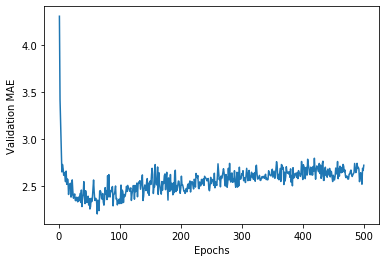

In [32]:
# 计算所有轮次中的 K 折验证分数平均值
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(500)]# 一共有500轮次
# 绘制验证分数
import matplotlib.pyplot as plt
plt.clf()
epochs = range(1, len(average_mae_history) + 1)
plt.plot(epochs, average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [33]:
# 因为纵轴的范围较大，且数据方差相对较大，所以难以看清这张图的规律。我们来重新绘制一张图。
#  删除前 10 个数据点，因为它们的取值范围与曲线上的其他点不同。
#  将每个数据点替换为前面数据点的指数移动平均值，以得到光滑的曲线。

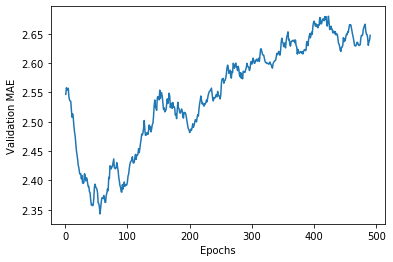

In [36]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points
smooth_mae_history = smooth_curve(average_mae_history[10:])
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [37]:
# 验证 MAE 在 70 轮后不再显著降低，之后就开始过拟合。
# 完成模型调参之后（除了轮数，还可以调节隐藏层大小），你可以使用最佳参数在所有训练数据上训练最终的生产模型，然后观察模型在测试集上的性能。
# 训练最终模型
model = build_model()
model.fit(train_data, train_targets,epochs=70, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
print(test_mse_score, test_mae_score)

102/102 [==============================] - 0s 2ms/step
17.986431047028187 2.7403316497802734


In [38]:
# 小结
# 回归问题使用的损失函数与分类问题不同。回归常用的损失函数是均方误差（MSE）。
#  同样，回归问题使用的评估指标也与分类问题不同。显而易见，精度的概念不适用于回
# 归问题。常见的回归指标是平均绝对误差（MAE）。
#  如果输入数据的特征具有不同的取值范围，应该先进行预处理，对每个特征单独进行
# 缩放。
#  如果可用的数据很少，使用 K 折验证可以可靠地评估模型。
#  如果可用的训练数据很少，最好使用隐藏层较少（通常只有一到两个）的小型网络，以
# 避免严重的过拟合。